# Aereal data to hex

This notebook __creates table 'hex_aereal_res{res}.gpkg'__, used in notebook that calculates HQSL.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [2]:
# 'alex' or 'edgar'
all_local_dirs = 'alex'
# Output hexs resolution
res = 9

In [10]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/processed/santiago/aereal_data/"
    count_pois_dir = "../../../data/external/temporal_fromjupyter/santiago/pois/"
    ndvi_dir = "../../../data/external/temporal_todocker/santiago/ndvi_santiago/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/00_pois_formated/aereal_data/"
    count_pois_dir = grl_dir
    ndvi_dir = grl_dir
else:
    print("WARNING: Fix all_local_dirs variable")

## Load data

### Load data - Housing

In [4]:
viv_gdf = gpd.read_file(count_pois_dir + 'casas_deptos_mzn.gpkg')
viv_gdf = viv_gdf[['osmid','total_viv','geometry']]
viv_gdf = viv_gdf.rename(columns={'total_viv':'viv_count'})
print(viv_gdf.shape)
viv_gdf.head(2)

(214430, 3)


,osmid,viv_count,geometry
0,14609420,20.126666,POINT (-70.75478 -33.51598)
1,266255164,21.028271,POINT (-70.79327 -33.52609)


### Load data - Offices

In [6]:
oficina_gdf = gpd.read_file(count_pois_dir + 'oficinas.gpkg')
oficina_gdf = oficina_gdf.rename(columns={'Oficinas':'oficinas_count'})
print(oficina_gdf.shape)
oficina_gdf.head(2)

(229965, 3)


,osmid,oficinas_count,geometry
0,386139,12.820194,POINT (-70.64725 -33.44313)
1,386140,0.008953,POINT (-70.64767 -33.44304)


### Load data - Hotels

In [7]:
hotel_gdf = gpd.read_file(count_pois_dir + 'usos_de_suelo.gpkg')
hotel_gdf = hotel_gdf[['osmid','HOTEL','geometry']].copy()
hotel_gdf = hotel_gdf.rename(columns={'HOTEL':'hotel_count'})
print(hotel_gdf.shape)
hotel_gdf.head(2)

(229965, 3)


,osmid,hotel_count,geometry
0,386139,14.213205,POINT (-70.64725 -33.44313)
1,386140,0.000000,POINT (-70.64767 -33.44304)


### Load data - Social housing

In [9]:
vivsoc_gdf = gpd.read_file(count_pois_dir + 'viv_social.gpkg')
vivsoc_gdf = vivsoc_gdf.rename(columns={'housing':'viv_social_count'})
print(vivsoc_gdf.shape)
vivsoc_gdf.head(2)

(34639, 3)


,osmid,viv_social_count,geometry
0,14528355,0.662426,POINT (-70.69014 -33.45685)
1,14805060,1.897061,POINT (-70.58526 -33.47253)


### Load data - NDVI

In [11]:
ndvi_gdf = gpd.read_file(ndvi_dir + f'Santiago_ndvi_HexRes{res}_v0.geojson')
ndvi_gdf = ndvi_gdf[['hex_id','res','ndvi_mean','geometry']]
ndvi_gdf = ndvi_gdf.rename(columns={'ndvi_mean':'ndvi_count'})
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(9170, 4)


,hex_id,res,ndvi_count,geometry
0,89b2c55085bffff,9,0.018576,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4..."
1,89b2c509dc7ffff,9,0.302082,"POLYGON ((-70.53795 -33.53054, -70.53912 -33.5..."


<Axes: >

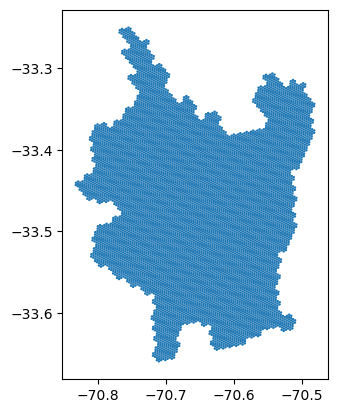

In [12]:
ndvi_gdf.plot()

### Load data - Area of interest

In [13]:
#aoi = gpd.read_file("../../../data/processed/santiago/santiago_aoi.gpkg")

query = 'SELECT * FROM projects_research.santiago_aoi'
aoi = aup.gdf_from_query(query)

# Show
print(aoi.shape)
aoi.head(1)

(1, 2)


,city,geometry
0,AM_Santiago,"MULTIPOLYGON (((-70.69165 -33.80508, -70.69167..."


## Create hex_gdf

In [14]:
hex_gdf = aup.create_hexgrid(aoi, res)

## Merge node data

In [15]:
node_aereal = viv_gdf.merge(oficina_gdf[['osmid','oficinas_count']], 
                            on='osmid', how='inner')
node_aereal = node_aereal.merge(hotel_gdf[['osmid','hotel_count']],
                               on='osmid', how='inner')
node_aereal = node_aereal.merge(vivsoc_gdf[['osmid','viv_social_count']],
                               on='osmid', how='left')
node_aereal = node_aereal.fillna(0)
print(node_aereal.shape)
node_aereal.head(2)

(199318, 6)


,osmid,viv_count,geometry,oficinas_count,hotel_count,viv_social_count
0,14609420,20.126666,POINT (-70.75478 -33.51598),0.0,0.0,0.0
1,266255164,21.028271,POINT (-70.79327 -33.52609),0.0,0.0,0.0


## Nodes to hex

In [16]:
hex_aereal = aup.group_by_hex_mean(node_aereal, hex_gdf, res,
                                  ['viv_count','oficinas_count',
                                  'hotel_count','viv_social_count'],
                                  f'hex_id_{res}')
print(hex_aereal.shape)
hex_aereal.head(4)

(30073, 6)


,hex_id_9,geometry,viv_count,oficinas_count,hotel_count,viv_social_count
0,89b2c540467ffff,"POLYGON ((-70.83528 -33.48877, -70.83645 -33.4...",0.0000,0.0,0.0,0.0
1,89b2c5c8923ffff,"POLYGON ((-70.74348 -33.27541, -70.74465 -33.2...",0.1649,0.0,0.0,0.0
2,89b2c0b6d67ffff,"POLYGON ((-70.77469 -33.76551, -70.77587 -33.7...",0.0000,0.0,0.0,0.0
3,89b2c5cd4cfffff,"POLYGON ((-70.73429 -33.27669, -70.73546 -33.2...",0.0000,0.0,0.0,0.0


In [17]:
if f'hex_id_{res}' in hex_aereal.columns:
    hex_aereal = hex_aereal.rename(columns={f'hex_id_{res}':'hex_id'})

hex_aereal = hex_aereal.merge(ndvi_gdf[['ndvi_count','hex_id']],
                             on='hex_id',
                             how='right')
# hex_aereal = hex_aereal.fillna(0)
print(hex_aereal.shape)
hex_aereal.head(4)

(9170, 7)


,hex_id,geometry,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",0.000000,0.000000,0.0,0.000000,0.018576
1,89b2c509dc7ffff,"POLYGON ((-70.53795 -33.53054, -70.53912 -33.5...",0.000000,0.000000,0.0,0.000000,0.302082
2,89b2c509ea3ffff,"POLYGON ((-70.56931 -33.53394, -70.57048 -33.5...",14.419467,0.045192,0.0,0.000000,0.155220
3,89b2c5553b7ffff,"POLYGON ((-70.73268 -33.45587, -70.73385 -33.4...",7.709645,0.129625,0.0,1.057783,0.147748


<Axes: >

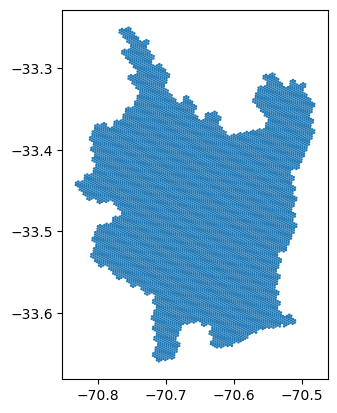

In [18]:
hex_aereal.plot()

### Save data

In [19]:
hex_aereal.to_file(grl_dir + f'hex_aereal_res{res}.gpkg')